In [16]:
# Common imports
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal

# Networking/packet analysis
import pyshark
import scapy.all as scapy
import networkx as nx

# Helper: inline plots
%matplotlib inline

# NyquistLab — Aliasing & Filters

**Goal:** Demonstrate aliasing when sampling below Nyquist, then remove it with filtering.


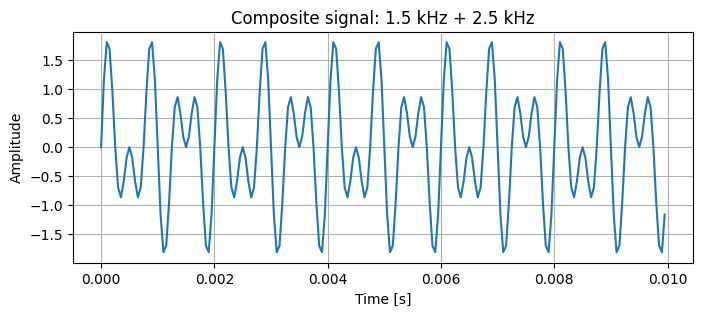

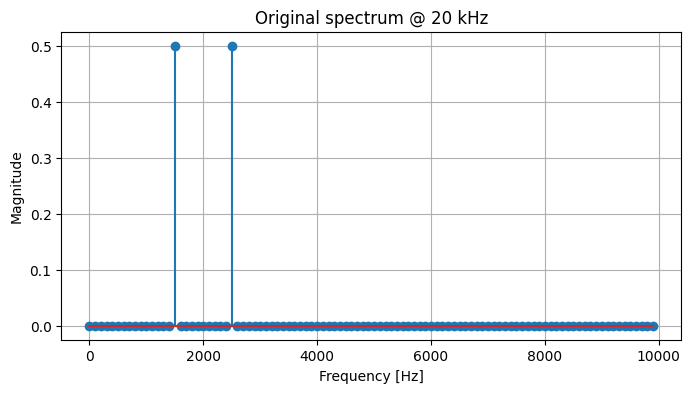

In [17]:
fs_true = 20_000   # high-rate "ground truth"
T = 0.01           # 10 ms window
t = np.arange(0, T, 1/fs_true)

f1, f2 = 1500, 2500  # Hz
sig = np.sin(2*np.pi*f1*t) + np.sin(2*np.pi*f2*t)

plt.figure(figsize=(8,3))
plt.plot(t[:200], sig[:200])  # zoom a bit
plt.title("Composite signal: 1.5 kHz + 2.5 kHz")
plt.xlabel("Time [s]"); plt.ylabel("Amplitude"); plt.grid(True); plt.show()

def plot_fft(sig, fs, title="Spectrum"):
    N = len(sig)
    freqs = np.fft.fftfreq(N, 1/fs)
    mag = np.abs(np.fft.fft(sig))/N
    plt.figure(figsize=(8,4))
    plt.stem(freqs[:N//2], mag[:N//2])

    plt.title(title); plt.xlabel("Frequency [Hz]"); plt.ylabel("Magnitude")
    plt.grid(True); plt.show()

plot_fft(sig, fs_true, "Original spectrum @ 20 kHz")


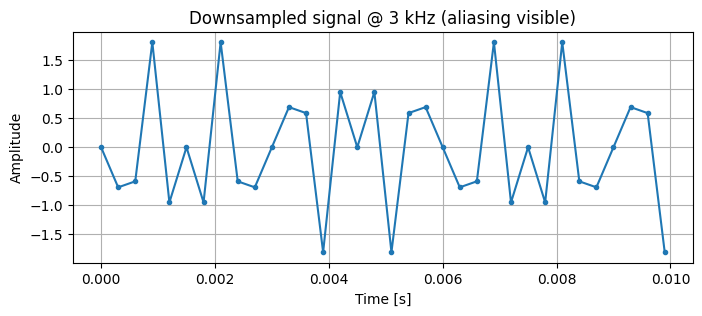

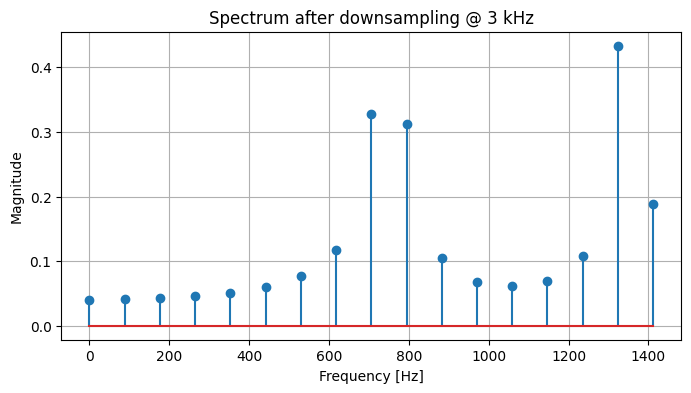

In [18]:
# Downsample to 3 kHz (below Nyquist)
fs_low = 3000
factor = int(fs_true / fs_low)
sig_low = sig[::factor]
t_low = t[::factor]

plt.figure(figsize=(8,3))
plt.plot(t_low[:200], sig_low[:200], 'o-', markersize=3)
plt.title("Downsampled signal @ 3 kHz (aliasing visible)")
plt.xlabel("Time [s]"); plt.ylabel("Amplitude"); plt.grid(True); plt.show()

plot_fft(sig_low, fs_low, "Spectrum after downsampling @ 3 kHz")

## 🧩 Discussion: Why Sampling Matters (and Why We Alias)

In the physical world, every signal — light, sound, voltage — varies *continuously*.
Computers cannot represent continuous phenomena directly; they store **discrete samples**.
Sampling replaces the infinite with the *finite*, allowing computation, storage, and transmission.

### 1. The Nyquist Idea
If a signal's highest frequency is \( f_{max} \), then the **Nyquist–Shannon sampling theorem** says we can perfectly reconstruct it from samples taken at:
\[
f_s \ge 2 f_{max}
\]
Any slower, and the signal *aliases* — high-frequency components fold back and appear as false low-frequency ones.

Aliasing happens in **all** digital systems:
- In **audio**, it sounds like metallic or “beating” tones.
- In **graphics**, it looks like jagged edges or shimmering textures.
- In **networks**, it causes bit errors when the receiver samples too slowly to distinguish signal transitions.

### 2. Why We “Nyquist” Instead of Recording Everything
Recording or transmitting an infinitely precise signal would require infinite bandwidth and storage.
Instead, we deliberately **limit** fidelity to what is meaningful for reconstruction:
- Cameras use pixel grids → spatial sampling
- Ethernet uses fixed symbol rates → temporal sampling
- 3D games limit frame rates and resolution → perceptual sampling

We *filter away* frequencies above the Nyquist limit before sampling — this is **anti-aliasing**.

So, we are not "cheating" by writing an aliased line.
We are *simulating what happens when the real world is under-sampled.*

### 3. Where Taylor Series Fits
A **Taylor series** expresses a continuous function \( f(x) \) as an infinite sum of polynomial terms around a point \( a \):
\[
f(x) = f(a) + f'(a)(x-a) + \frac{f''(a)}{2!}(x-a)^2 + \ldots
\]

This gives us *local approximations* of a continuous curve using discrete information — its derivatives.
Sampling does something similar in time: it replaces a continuous curve with discrete points.

So, Taylor series ≈ *mathematical approximation* of smoothness,
Sampling ≈ *physical approximation* of continuity.

Both say:
> “We can’t hold the infinite, but we can approximate it well enough — with finite information.”

### 4. In Engineering and Art
| Domain | What’s Sampled | What Happens if Under-Sampled |
|---------|----------------|-------------------------------|
| Audio | Sound wave | Aliasing noise or metallic artifacts |
| Graphics | Light field | Jagged edges, moiré patterns |
| Netwo


### 🧠 Advanced Note — The Frequency View of Information

In the **frequency domain**, every continuous signal can be seen as a mixture of pure sinusoids — its **Fourier components**.
Each component’s frequency corresponds to how quickly the signal changes in time.

When we sample a signal, we are effectively placing a **limit on how much variation** we can represent.
The **highest recoverable frequency** is the Nyquist frequency:
\[
f_N = \frac{f_s}{2}
\]

Everything above \( f_N \) becomes **ambiguous** — it folds (aliases) into the lower band.

Thus, all information that can be reliably reconstructed is *contained* within the **band of frequencies below \( f_N \)**.

This means:
- The **frequency spectrum** tells us exactly *how much of the original signal we can keep*.
- The **lost upper frequencies** are like details finer than your pixel grid — once gone, they cannot be recovered.

In visual or physical terms:
- A low-frequency signal = broad, smooth structures → easy to reconstruct.
- High frequencies = fine edges or rapid transitions → lost if sampling too slow.
- The "small slivers" you mentioned correspond to those fine oscillations — *they vanish* below Nyquist because their energy folds back into lower, incorrect frequencies.

So, Nyquist’s theorem is not just a rule about sample rates — it’s a **boundary on information density**.
It defines the line between what can be represented faithfully and what must disappear or distort.


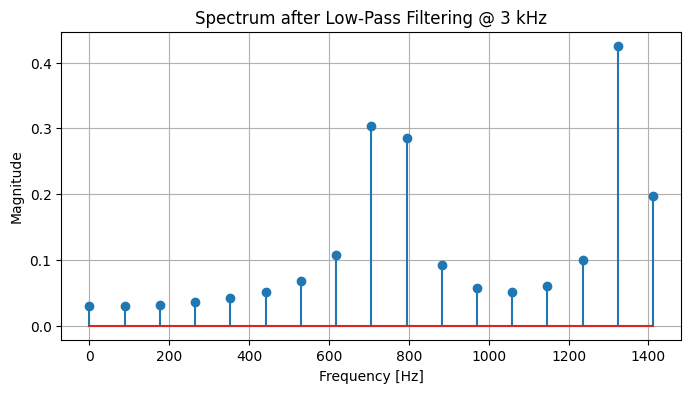

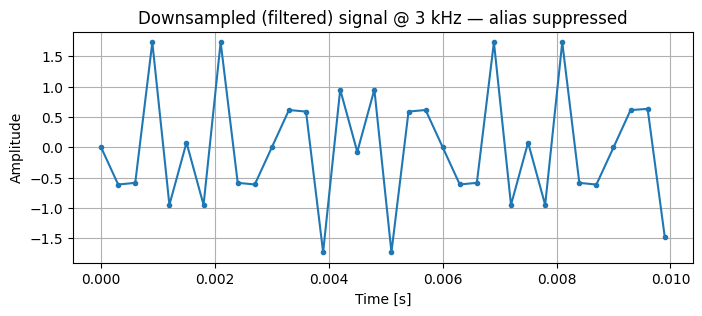

In [21]:
# Anti-alias filtering before downsampling
from scipy.signal import butter, filtfilt

# Define a low-pass filter with cutoff just below the Nyquist limit (for fs_low)
def lowpass_filter(data, fs, cutoff_ratio=0.45):
    cutoff = (fs / 2) * cutoff_ratio
    b, a = butter(6, cutoff / (fs / 2), btype='low')
    return filtfilt(b, a, data)

# Filter original high-rate signal before decimation
sig_filtered = lowpass_filter(sig, fs_true, cutoff_ratio=0.3)

# Downsample the filtered signal
sig_low_filt = sig_filtered[::factor]
t_low_filt = t[::factor]

# Compare results
plot_fft(sig_low_filt, fs_low, "Spectrum after Low-Pass Filtering @ 3 kHz")

plt.figure(figsize=(8,3))
plt.plot(t_low_filt[:200], sig_low_filt[:200], 'o-', markersize=3)
plt.title("Downsampled (filtered) signal @ 3 kHz — alias suppressed")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()


### Networking Analogy — Filtering at the Physical Layer

Anti-alias filters in signal processing are conceptually the same as **line coding filters** and **equalizers** in network transceivers:

| Concept | Purpose | Networking Example |
|----------|----------|--------------------|
| Anti-alias filter | Remove frequencies above Nyquist before sampling | Ethernet PHY filters unwanted harmonics before the ADC samples the waveform |
| Nyquist rate | Defines max symbol rate for given bandwidth | Sets max bits per second on a cable |
| Aliasing | High-frequency energy misinterpreted as lower-frequency bits | Timing jitter or crosstalk causing bit errors |
| Low-pass filter design | Preserve signal below cutoff, reject noise | RJ-45 twisted-pair + transceiver filters shaping signal edges |

Thus, **digital communication depends on physical Nyquist discipline**:
every cable, transceiver, and clock obeys the same law — sample fast enough and filter what you can’t handle.

When you perform ARP, TCP handshakes, or CSMA/CD timing analysis in later labs, the same constraint governs how fast those electrical pulses can be recognized as “1” and “0” by the receiver.


At 10 Mbps Ethernet, bit time ≈ 100 ns → Nyquist frequency ≈ 5 MHz.
Cables, transformers, and filters are all designed so that the analog bandwidth comfortably exceeds 5 MHz.
Any aliasing of higher-frequency harmonics would manifest as timing distortion — effectively the same phenomenon we just visualized in NyquistLab.


In [24]:
# Shannon-style capacity estimate for the filtered signal
# (illustrating how Nyquist bandwidth and SNR define data signal)

snr_db = 30 # assume 30 dB line quality
snr_linear = 10**(snr_db/10)

bw = fs_low / 2 # effective channel bandwidth = Nyquist freq
capacity = bw * np.log2(1 + snr_linear) # bits per second, Shannon formula

print(f"Effective channel bandwidth: {bw/1000:.2f} kHz")
print(f"Estimated theoretical capacity: {capacity/1000:.2f} kBit/s")

Effective channel bandwidth: 1.50 kHz
Estimated theoretical capacity: 14.95 kBit/s


### Networking Interpretation — Nyquist Meets Shannon

At the physical layer, *sampling rate defines bandwidth*.
Shannon’s theorem extends Nyquist by adding **noise** and **signal-to-noise ratio (SNR)**:
\[
C = B \log_2(1 + \mathrm{SNR})
\]
- \(B\) = bandwidth = \(f_s / 2\)
- \(C\) = channel capacity (bits /s)
- \( \mathrm{SNR} \) = signal-to-noise ratio

In Ethernet or Wi-Fi, the symbol rate (baud) ≈ 2 × bandwidth, and coding efficiency determines how close we get to this limit.
This bridges the physics of sampling with the logic of protocols:
- **PHY layer:** bandwidth and noise set raw bit rate.
- **MAC layer:** CSMA/CD or CSMA/CA manages shared medium timing.
- **Transport layer:** TCP measures RTT and adjusts rate based on observed capacity.


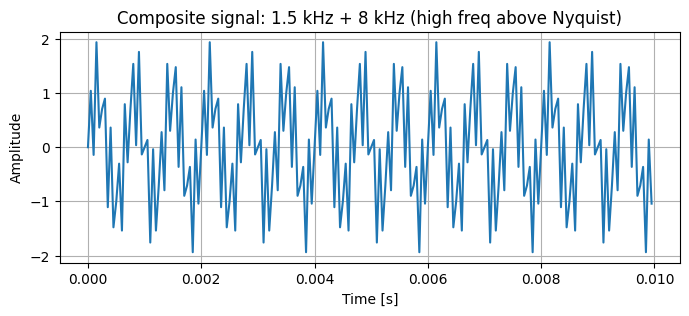

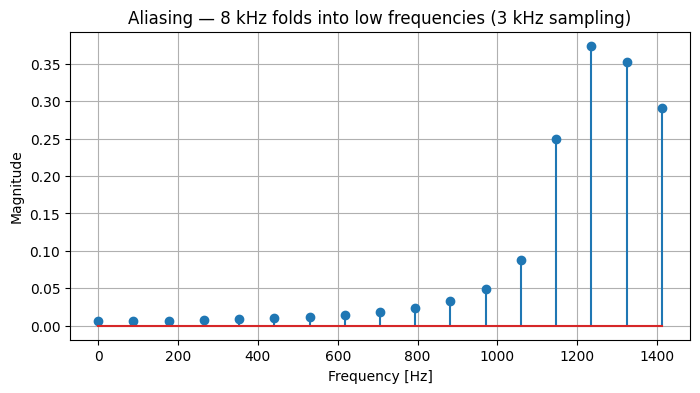

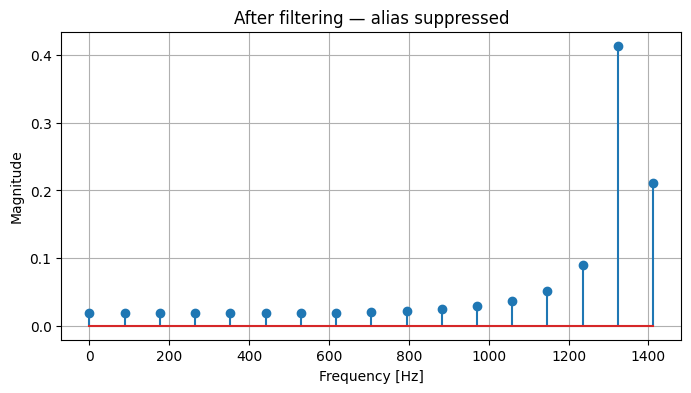

In [25]:
# Stronger aliasing demo: push f2 above the Nyquist limit for fs_low = 3 kHz
f1, f2 = 1500, 8000
sig_high = np.sin(2*np.pi*f1*t) + np.sin(2*np.pi*f2*t)

plt.figure(figsize=(8,3))
plt.plot(t[:200], sig_high[:200])
plt.title("Composite signal: 1.5 kHz + 8 kHz (high freq above Nyquist)")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

# Downsample without filtering
sig_high_low = sig_high[::factor]
plot_fft(sig_high_low, fs_low, "Aliasing — 8 kHz folds into low frequencies (3 kHz sampling)")

# Compare filtered version
sig_high_filt = lowpass_filter(sig_high, fs_true, cutoff_ratio=0.3)
sig_high_low_filt = sig_high_filt[::factor]
plot_fft(sig_high_low_filt, fs_low, "After filtering — alias suppressed")


### Visualizing True Aliasing

When a frequency lies above the Nyquist limit, the sampler can’t tell it apart from a different lower frequency.
The relationship follows:
\[
f_\text{alias} = |f - N f_s|, \quad N = \text{nearest integer}
\]

For \( f_2 = 8 \text{ kHz}, f_s = 3 \text{ kHz} \):
\[
f_\text{alias} = |8 - 2 \times 3| = 2 \text{ kHz}
\]

Thus, the sampler **interprets 8 kHz as 2 kHz** — a completely wrong but perfectly smooth wave.
Filtering removes that component before sampling, ensuring the receiver never “sees” false energy.
